# 1. Load data

In [1]:
# Libraries for data preprossing and feature extraction
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
import string
from nltk.corpus import stopwords
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

#libraries for clustering
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MeanShift
from sklearn.decomposition import PCA

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#Load csv file
df = pd.read_csv('full-corpus.csv')

In [3]:
#To select only data we need
df = df[df["Sentiment"] != 'irrelevant']
x = df["TweetText"].values.tolist()
y = df["Sentiment"].values.tolist()

In [4]:
x

['Now all @Apple has to do is get swype on the iphone and it will be crack. Iphone that is',
 '@Apple will be adding more carrier support to the iPhone 4S (just announced)',
 "Hilarious @youtube video - guy does a duet with @apple 's Siri. Pretty much sums up the love affair! http://t.co/8ExbnQjY",
 '@RIM you made it too easy for me to switch to @Apple iPhone. See ya!',
 'I just realized that the reason I got into twitter was ios5 thanks @apple',
 "I'm a current @Blackberry user, little bit disappointed with it! Should I move to @Android or @Apple @iphone",
 'The 16 strangest things Siri has said so far. I am SOOO glad that @Apple gave Siri a sense of humor! http://t.co/TWAeUDBp via @HappyPlace',
 'Great up close & personal event @Apple tonight in Regent St store!',
 'From which companies do you experience the best customer service aside from @zappos and @apple?',
 'Just apply for a job at @Apple, hope they call me lol',
 'RT @JamaicanIdler: Lmao I think @apple is onto something magica

# 2. Data Pre-Processing

In [5]:
# To split data to training and testing data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [6]:
print("Training Data size: ", len(x_train))
print("Testing Data size: ", len(x_test))

Training Data size:  2739
Testing Data size:  685


In [7]:
print(x_train[1102])
print(y_train[1102])

I lovee #Twitter   #swaag!
positive


In [8]:
def clean_data(x, y):
    
    text_data = []
    stop_words = set(stopwords.words('english')) 
    #print('stop_words: ', stop_words)
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    x = [i.lower() for i in x]

    for text in x:
        tokens = text.split()
        tokens = [re_punc.sub('', w) for w in tokens]        # remove punctuation
        tokens = [word for word in tokens if word.isalpha()] # remove word that are not alphabetic
        tokens = [w for w in tokens if not w in stop_words]  # remove stop_word
        tokens = [word for word in tokens if len(word)>1]    # remove short word
        text_data.append(tokens)
        
    label = []
    for i in y:
        if i == 'positive':
            label.append(2)
        elif i == 'negative':
            label.append(0)
        elif i == 'neutral':
            label.append(1)
        else:
            print(i)
    return text_data, label

In [9]:
# To clean data
train_x, train_y = clean_data(x_train, y_train)
test_x, test_y = clean_data(x_test, y_test)

In [10]:
train_x[0]

['vincent', 'mugambi', 'microsoft', 'takes', 'us', 'wp', 'app']

In [11]:
train_y[0]

1

# 3. Feature Extraction

In [12]:
def extract_BoW_features(words_train, words_test):
    
    vocab_list = []

    for word in words_train:
        if word not in vocab_list:
            vocab_list.append(word)
    vocabulary_size = len(vocab_list)

    vectorizer = CountVectorizer(max_features=vocabulary_size, preprocessor=lambda words_train: words_train, tokenizer=lambda words_train: words_train)  
    features_train = vectorizer.fit_transform(words_train).toarray()
    features_test = vectorizer.transform(words_test).toarray()

    vocabulary = vectorizer.vocabulary_

    return features_train, features_test, vocabulary

In [13]:
# To extract Bag of Words features for both training and test datasets
train_x, test_x, vocabulary = extract_BoW_features(train_x, test_x)

In [14]:
train_x.shape

(2739, 2618)

In [15]:
len(vocabulary)

2618

# 4. Classification (Clustering)

In [16]:
#4.1 Kmean

kmeans = KMeans(n_clusters=3, random_state=0).fit(train_x)
y_pred_kmean = kmeans.labels_
accuracy_score(train_y, y_pred_kmean)

0.3859072654253377

In [17]:
#4.2 MiniBatchKMeans

minikmeans = MiniBatchKMeans(n_clusters=3, random_state=0, batch_size=6)
minikmeans = minikmeans.partial_fit(train_x)
y_pred_minikmeans = minikmeans.labels_
accuracy_score(train_y, y_pred_minikmeans)

0.5268346111719606

In [18]:
#4.3 SpectralClustering

Spectral_clustering = SpectralClustering(n_clusters=3, assign_labels="discretize", random_state=0).fit(train_x)
y_pred_spectral = Spectral_clustering.labels_
accuracy_score(train_y, y_pred_spectral)

0.1591821832785688

In [19]:
#4.4 AgglomerativeClustering

agg_clustering = AgglomerativeClustering(n_clusters=3).fit(train_x)
y_pred_agg_clustering = agg_clustering.labels_
accuracy_score(train_y, y_pred_agg_clustering)

0.31507849580138736

In [20]:
#4.5 MeanShift

meanshift_clustering = MeanShift(bandwidth=3).fit(train_x)
y_pred_MeanShift =meanshift_clustering.labels_
accuracy_score(train_y, y_pred_MeanShift)

0.12194231471339904

# 5. Apply PCA for improvement

In [21]:
#To run PCA
def pca(step_size, train_x):
    pca = PCA(n_components=step_size)
    pca.fit(train_x)
    return pca.transform(train_x)

In [22]:
#To feed data from PCA to clustering method

n_component_list = []
accuracy_list = []

for i in range(100, 2700, 100):
    train_x_pca = pca(i, train_x)
    pca_kmeans_batch = MiniBatchKMeans(n_clusters=3, random_state=0, batch_size=6)
    pca_kmeans_batch = pca_kmeans_batch.partial_fit(train_x_pca)
    y_pred_pca_kmeans_batch = pca_kmeans_batch.labels_
    accuracy = accuracy_score(train_y, y_pred_pca_kmeans_batch)
    print('n_component: ', i, 'accuracy: ', accuracy)
    n_component_list.append(i)
    accuracy_list.append(accuracy)

n_component:  100 accuracy:  0.2194231471339905
n_component:  200 accuracy:  0.27455275648046734
n_component:  300 accuracy:  0.37568455640744797
n_component:  400 accuracy:  0.5578678349762687
n_component:  500 accuracy:  0.21978824388462942
n_component:  600 accuracy:  0.22015334063526834
n_component:  700 accuracy:  0.22380430814165753
n_component:  800 accuracy:  0.2230741146403797
n_component:  900 accuracy:  0.2230741146403797
n_component:  1000 accuracy:  0.2230741146403797
n_component:  1100 accuracy:  0.6356334428623586
n_component:  1200 accuracy:  0.6356334428623586
n_component:  1300 accuracy:  0.6356334428623586
n_component:  1400 accuracy:  0.6173786053304126
n_component:  1500 accuracy:  0.6173786053304126
n_component:  1600 accuracy:  0.6173786053304126
n_component:  1700 accuracy:  0.6173786053304126
n_component:  1800 accuracy:  0.6173786053304126
n_component:  1900 accuracy:  0.6411098941219423
n_component:  2000 accuracy:  0.6414749908725812
n_component:  2100 accur

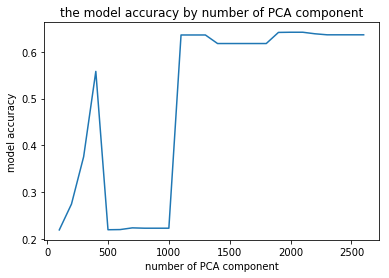

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(n_component_list, accuracy_list)
plt.title('the model accuracy by number of PCA component')
plt.xlabel('number of PCA component')
plt.ylabel('model accuracy')
plt.savefig('pca.png')
plt.show()

# 6.1 Evaluation of 5 Models

In [24]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [25]:
model_performance_dict = {}
model_obj = {'Kmean': kmeans,
            'MiniBatchKMeans': minikmeans,
            'SpectralClustering': Spectral_clustering,
            'AgglomerativeClustering': agg_clustering,
            'MeanShift': meanshift_clustering}

for model in model_obj:
    print('model: ', model)
    #Calculate predicted data
    if model not in ['SpectralClustering', 'AgglomerativeClustering']:
        predict_test_y = model_obj[model].predict(test_x)
        predict_train_y = model_obj[model].labels_
    else:
        predict_test_y = model_obj[model].fit_predict(test_x)
        predict_train_y = model_obj[model].fit_predict(train_x)
    
    training_accuracy = accuracy_score(train_y, predict_train_y)
    testing_accuracy = accuracy_score(test_y, predict_test_y)
    re_call = recall_score(test_y, predict_test_y, average='weighted')
    precision = precision_score(test_y, predict_test_y, average='weighted')
    f_score = f1_score(test_y, predict_test_y, average='weighted')
    
    model_performance_dict[model] = {'training_accuracy': training_accuracy,
                                    'testing_accuracy': testing_accuracy,
                                    're_call': re_call,
                                    'precision': precision,
                                    'f_score': f_score}


model:  Kmean
model:  MiniBatchKMeans
model:  SpectralClustering
model:  AgglomerativeClustering
model:  MeanShift


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [26]:
model_performance_dict

{'Kmean': {'training_accuracy': 0.3859072654253377,
  'testing_accuracy': 0.3605839416058394,
  're_call': 0.3605839416058394,
  'precision': 0.41393953414684914,
  'f_score': 0.3841823458336142},
 'MiniBatchKMeans': {'training_accuracy': 0.5268346111719606,
  'testing_accuracy': 0.5153284671532846,
  're_call': 0.5153284671532846,
  'precision': 0.4904817261061826,
  'f_score': 0.4963602477769185},
 'SpectralClustering': {'training_accuracy': 0.1591821832785688,
  'testing_accuracy': 0.20437956204379562,
  're_call': 0.20437956204379562,
  'precision': 0.6948990983254616,
  'f_score': 0.07378769257005295},
 'AgglomerativeClustering': {'training_accuracy': 0.31507849580138736,
  'testing_accuracy': 0.27883211678832115,
  're_call': 0.27883211678832115,
  'precision': 0.5023900566182923,
  'f_score': 0.3126782310661359},
 'MeanShift': {'training_accuracy': 0.12194231471339904,
  'testing_accuracy': 0.20145985401459854,
  're_call': 0.20145985401459854,
  'precision': 0.6955368585278877,

In [27]:
pd.DataFrame.from_dict(model_performance_dict)

,Kmean,MiniBatchKMeans,SpectralClustering,AgglomerativeClustering,MeanShift
f_score,0.384182,0.496360,0.073788,0.312678,0.077294
precision,0.413940,0.490482,0.694899,0.502390,0.695537
re_call,0.360584,0.515328,0.204380,0.278832,0.201460
testing_accuracy,0.360584,0.515328,0.204380,0.278832,0.201460
training_accuracy,0.385907,0.526835,0.159182,0.315078,0.121942


# 6.2 Evaluation of the improved model

In [28]:
#To evaluate the selected model
model = 'MiniBatchKMeans_pca'
pca_n_component = 2000 #this provides the highest model accuracy

#PCA
selected_pca = PCA(n_components=pca_n_component)
selected_pca = selected_pca.fit(train_x)
train_x_pca = selected_pca.transform(train_x)
test_x_pca = selected_pca.transform(test_x)

#KMean Mini Batch
pca_kmeans_batch = MiniBatchKMeans(n_clusters=3, random_state=0, batch_size=6)
pca_kmeans_batch = pca_kmeans_batch.partial_fit(train_x_pca)

#Calculate Model Performance
predict_train_y = pca_kmeans_batch.labels_
predict_test_y = pca_kmeans_batch.predict(test_x_pca)

training_accuracy = accuracy_score(train_y, predict_train_y)
testing_accuracy = accuracy_score(test_y, predict_test_y)
re_call = recall_score(test_y, predict_test_y, average='weighted')
precision = precision_score(test_y, predict_test_y, average='weighted')
f_score = f1_score(test_y, predict_test_y, average='weighted')

model_performance_dict[model] = {'training_accuracy': training_accuracy,
                                    'testing_accuracy': testing_accuracy,
                                    're_call': re_call,
                                    'precision': precision,
                                    'f_score': f_score}

In [29]:
pd.DataFrame.from_dict(model_performance_dict)

,Kmean,MiniBatchKMeans,SpectralClustering,AgglomerativeClustering,MeanShift,MiniBatchKMeans_pca
f_score,0.384182,0.496360,0.073788,0.312678,0.077294,0.520964
precision,0.413940,0.490482,0.694899,0.502390,0.695537,0.461700
re_call,0.360584,0.515328,0.204380,0.278832,0.201460,0.608759
testing_accuracy,0.360584,0.515328,0.204380,0.278832,0.201460,0.608759
training_accuracy,0.385907,0.526835,0.159182,0.315078,0.121942,0.641840


In [30]:
model_performance_dict['MiniBatchKMeans_pca']

{'training_accuracy': 0.6418400876232202,
 'testing_accuracy': 0.6087591240875913,
 're_call': 0.6087591240875913,
 'precision': 0.46170001830723073,
 'f_score': 0.520964143183283}

In [31]:
from sklearn.metrics import classification_report

In [32]:
class_names = np.array(['negative', 'neutral', 'positive'])
print(classification_report(test_y, predict_test_y, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       138
     neutral       0.65      0.89      0.75       448
    positive       0.27      0.17      0.21        99

   micro avg       0.61      0.61      0.61       685
   macro avg       0.30      0.35      0.32       685
weighted avg       0.46      0.61      0.52       685

